# Install and Import Dependencies

In [149]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import unicodedata
import nltk
from nltk.corpus import stopwords
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load data

The dataset for this project will be obtained through web scraping from the official IMDB website.

## Web Crawling settings

In [2]:
# Configure Selenium to run in headless mode (without graphical interface)
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Set the User-Agent to simulate a real browser
chrome_options.add_argument(
    "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
)
chrome_options.add_argument("--lang=en-US")


# Initialize the browser
driver = webdriver.Chrome(options=chrome_options)

# Access IMDB page
url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
driver.get(url)

time.sleep(10)

# Obtain the HTML rendered by Selenium
html = driver.page_source

headers = {
    'authority': 'www.amazon.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-US,en;q=0.9,pt;q=0.8',
    'cache-control': 'max-age=0',
    'device-memory': '8',
    'downlink': '10',
    'dpr': '1.875',
    'ect': '4g',
    'rtt': '50',
    'sec-ch-device-memory': '8',
    'sec-ch-dpr': '1.875',
    'sec-ch-ua': '"Chromium";v="110", "Not A(Brand";v="24", "Google Chrome";v="110"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-ch-ua-platform-version': '"10.0.0"',
    'sec-ch-viewport-width': '455',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'none',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
    'viewport-width': '455',
}

In [3]:
bs = BeautifulSoup(html)

### Extracting data (Genre, Title, Year, Synopsis and Rating)

In [4]:
list_rating = []

# Step 3: Locate the relevant element
rating_span = bs.find_all('span', class_='ipc-rating-star--rating')
for x in rating_span:
  list_rating.append(x.text)

print(len(list_rating))

250


In [5]:
list_links = []
# Find all <a> elements with the href attribute.
for a in bs.find_all('a', href=True):
    href = a['href']
    
    # Check if the link contains '/title/' and follows the specific format 'ref_=chttp_t_'.
    if '/title/' in href and 'ref_=chttp_t_' in href:
        # Build the complete url
        full_link = 'https://www.imdb.com' + href
        
        if full_link not in list_links:
            list_links.append(full_link)

# Drop duplicates
list_links = list(dict.fromkeys(list_links))

print(len(list_links))

250


In [6]:
list_genre = []
list_title_en = []
list_year = []
list_synopsis = []

for link in list_links:
    time.sleep(.5)
    response = requests.get(link, headers=headers)
    html = response.content
    soup = BeautifulSoup(html, "html.parser")

    # Genre
    try:
        for genre in soup.find('span', {'class': 'ipc-chip__text'}):
            genre = genre.text
            list_genre.append(genre)
    except:
        list_genre.append(np.nan)
        print('Nan')

    # Title_EN and Year
    try:
        for x in soup.find('title'):
            # Title_EN
            title_en = (x.text)[:-14].strip()
            list_title_en.append(title_en)
            
            # Year
            year = (x.text)[-12:-8].strip()
            list_year.append(year)

    except:
        list_title_en.append(np.nan)
        list_year.append(np.nan)

    # Synopsis
    try:
        for sin in soup.find('span', {"data-testid": "plot-xl"}):
            synopsis = sin.text
            list_synopsis.append(synopsis)
    except:
        list_synopsis.append(np.nan)

    print('Genre:', genre, 'Title:', title_en, 'Year:', year, 'Synopsis:', synopsis[:20])

Genre: Epic Title: The Shawshank Redemption Year: 1994 Synopsis: A banker convicted o
Genre: Epic Title: The Godfather Year: 1972 Synopsis: The aging patriarch 
Genre: Action Epic Title: The Dark Knight Year: 2008 Synopsis: When a menace known 
Genre: Epic Title: The Godfather Part II Year: 1974 Synopsis: The early life and c
Genre: Legal Drama Title: 12 Angry Men Year: 1957 Synopsis: The jury in a New Yo
Genre: Epic Title: Schindler's List Year: 1993 Synopsis: In German-occupied P
Genre: Adventure Epic Title: The Lord of the Rings: The Return of the King Year: 2003 Synopsis: Gandalf and Aragorn 
Genre: Dark Comedy Title: Pulp Fiction Year: 1994 Synopsis: The lives of two mob
Genre: Adventure Epic Title: The Lord of the Rings: The Fellowship of the Ring Year: 2001 Synopsis: A meek Hobbit from t
Genre: Desert Adventure Title: The Good, the Bad and the Ugly Year: 1966 Synopsis: A bounty hunting sca
Genre: Epic Title: Forrest Gump Year: 1994 Synopsis: The history of the U
Genre: Adventure

# Descriptive Analysis

In [7]:
df = pd.DataFrame({'title_en':list_title_en,
                   'year':list_year,
                   'rating':list_rating,
                   'genre':list_genre,
                   'synopsis':list_synopsis})

df.sort_values('year', inplace = True)

print(df.shape)
df.head()

(250, 5)


,title_en,year,rating,genre,synopsis
133,The Kid,1921,8.2,Buddy Comedy,"The Tramp cares for an abandoned child, but ev..."
199,Sherlock Jr.,1924,8.2,Bumbling Detective,"A film projectionist longs to be a detective, ..."
194,The Gold Rush,1925,8.1,Farce,A prospector goes to the Klondike during the 1...
198,The General,1926,8.1,Farce,After being rejected by the Confederate milita...
119,Metropolis,1927,8.3,Dystopian Sci-Fi,In a futuristic city sharply divided between t...


In [80]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_en  250 non-null    object 
 1   year      250 non-null    int64  
 2   rating    250 non-null    float64
 3   genre     250 non-null    object 
 4   synopsis  250 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 9.9+ KB


In [22]:
df.describe()

,year,rating
count,250.000000,250.000000
mean,1987.600000,8.308800
std,25.517141,0.235082
min,1921.000000,8.000000
25%,1968.750000,8.100000
50%,1995.000000,8.200000
75%,2007.750000,8.400000
max,2024.000000,9.300000


# Exploratory Data Analysis

## Movies per genre

In [23]:
fig = px.bar(df['genre'].value_counts('d')*100,
             text_auto=True,
             title = '% of Movies per Genre',
             labels={'index':'Genre',
                     'value':'% of Movies'})
fig.show()

## Movies per Year

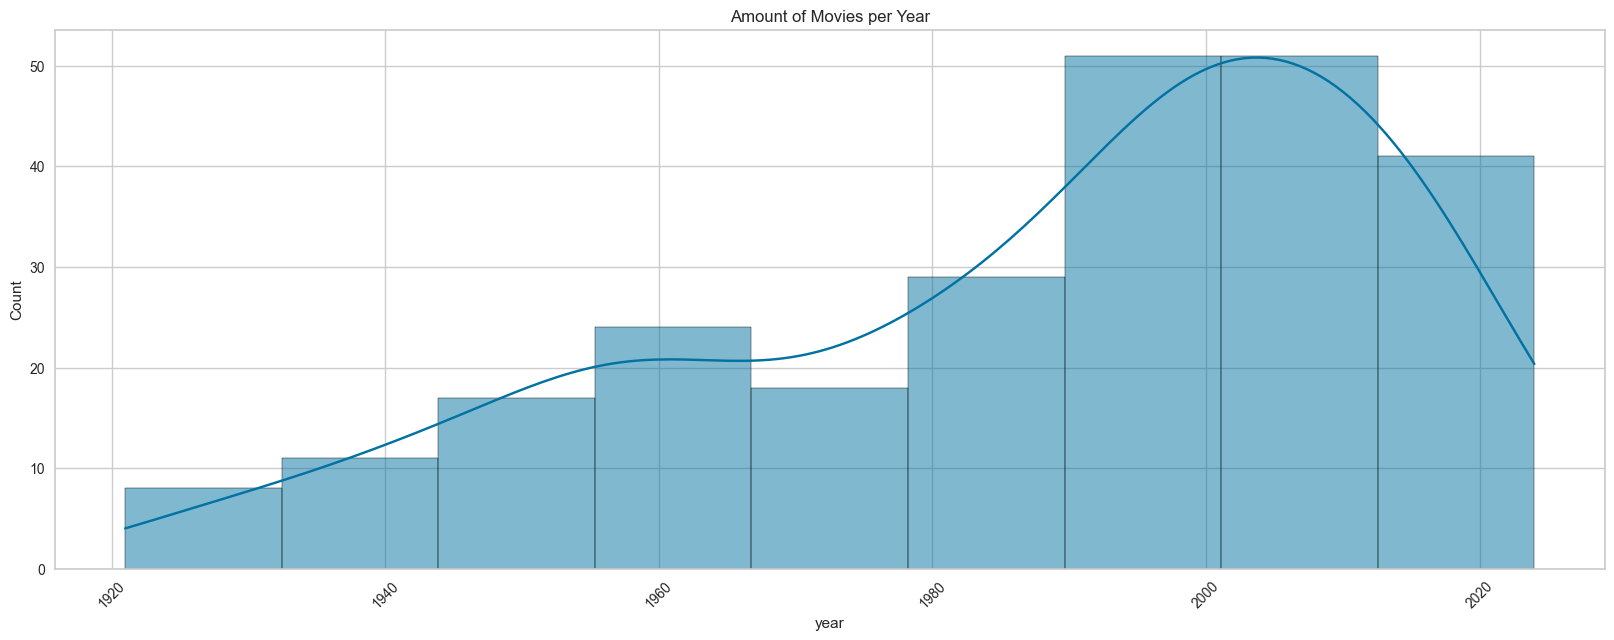

In [24]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True).set_title('Amount of Movies per Year')

plt.xticks(rotation=45)
plt.show()

## Movies per Year and Genre

In [81]:
genre_mapping = {
    'Buddy Comedy': 'Comedy',
    'Bumbling Detective': 'Comedy',
    'Farce': 'Comedy',
    'Dystopian Sci-Fi': 'Sci-Fi',
    'Legal Drama': 'Drama',
    'Feel-Good Romance': 'Romance',
    'Psychological Thriller': 'Thriller',
    'Road Trip': 'Adventure',
    'Slapstick': 'Comedy',
    'Epic': 'Drama',
    'Classic Musical': 'Musical',
    'Political Drama': 'Drama',
    'Dark Romance': 'Romance',
    'Parody': 'Comedy',
    'Drama': 'Drama',
    'Screwball Comedy': 'Comedy',
    'Film Noir': 'Thriller',
    'Tragedy': 'Drama',
    'Crime': 'Crime',
    'Showbiz Drama': 'Drama',
    'Psychological Drama': 'Drama',
    'Suspense Mystery': 'Mystery',
    'Action Epic': 'Action',
    'Jungle Adventure': 'Adventure',
    'Adventure Epic': 'Adventure',
    'Spy': 'Action',
    'Holiday Comedy': 'Comedy',
    'Psychological Horror': 'Horror',
    'One-Person Army Action': 'Action',
    'Period Drama': 'Drama',
    'Police Procedural': 'Drama',
    'Dark Comedy': 'Comedy',
    'Docudrama': 'Drama',
    'Desert Adventure': 'Adventure',
    'Prison Drama': 'Drama',
    'Supernatural Horror': 'Horror',
    'Caper': 'Crime',
    'Conspiracy Thriller': 'Thriller',
    'Sea Adventure': 'Adventure',
    'Adventure': 'Adventure',
    'Medical Drama': 'Drama',
    'Workplace Drama': 'Drama',
    'Boxing': 'Sport',
    'War Epic': 'Drama',
    'Cyberpunk': 'Sci-Fi',
    'Alien Invasion': 'Sci-Fi',
    'Artificial Intelligence': 'Sci-Fi',
    'Drug Crime': 'Crime',
    'Costume Drama': 'Drama',
    'Car Action': 'Action',
    'Samurai': 'Action',
    'Coming-of-Age': 'Drama',
    'Anime': 'Animation',
    'Adult Animation': 'Animation',
    'Gangster': 'Crime',
    'Dinosaur Adventure': 'Adventure',
    'Animal Adventure': 'Adventure',
    'Cop Drama': 'Drama',
    'Romantic Comedy': 'Romance',
    'High-Concept Comedy': 'Comedy',
    'Satire': 'Comedy',
    'Martial Arts': 'Action',
    'Computer Animation': 'Animation',
    'Political Thriller': 'Thriller',
    'Contemporary Western': 'Western',
    'Comedy': 'Comedy',
    'Dark Fantasy': 'Fantasy',
    'Erotic Thriller': 'Thriller',
    'Action': 'Action',
    'Space Sci-Fi': 'Sci-Fi',
    'Hand-Drawn Animation': 'Animation',
    'Biography': 'Drama',
    'Superhero': 'Action',
}

df['genre_grouped'] = df['genre'].map(genre_mapping)

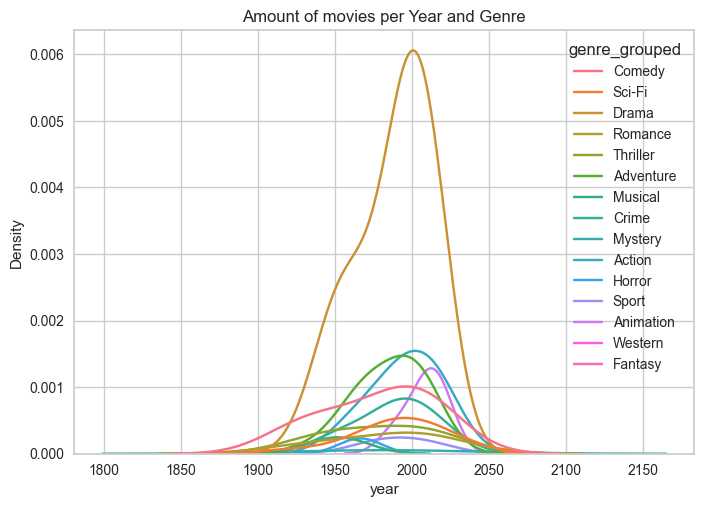

In [28]:
sns.kdeplot(df, x='year', hue='genre_grouped', bw_adjust=1.5, warn_singular=False).set_title('Amount of movies per Year and Genre')
plt.show()

# Pre-processing text

## Normalization NFD

Normalization ‘NFD’ (Normalization Form D) breaks down accented characters into their basic components. For example, the letter “á” is decomposed into “a” and the accent.

In this step, i also prefer to convert everything to lowercase.

In [82]:
def normalize_and_count(text):
    normalized_text = unicodedata.normalize('NFD', text).lower()
    return normalized_text, normalized_text != text

df['synopsis'], adjustments = zip(*df['synopsis'].apply(normalize_and_count))

adjustment_count = sum(adjustments)

print(f"Number of adjustments made: {adjustment_count}")

Number of adjustments made: 250


## Removing special characters

In [83]:
def encode_and_count(text):
    encoded_text = text.encode('ascii', 'ignore').decode('utf-8')
    return encoded_text, encoded_text != text

df['synopsis'], adjustments = zip(*df['synopsis'].apply(encode_and_count))

adjustment_count = sum(adjustments)

print(f"Number of adjustments made: {adjustment_count}")

Number of adjustments made: 2


## Removing stop-words

Stop words are words that, on their own, do not provide much meaning and are often ignored by search engines when indexing content. These words include articles, prepositions, conjunctions, and pronouns, among others. The goal of ignoring them is to focus on the most relevant keywords to enhance efficiency in searching and text analysis.

In [84]:
stop_words_en = stopwords.words('english')
df['synopsis'] = df['synopsis'].replace(to_replace=r'[,.!?\']', value='', regex=True)

print(f"{stop_words_en[0:5]}, etc.")

['i', 'me', 'my', 'myself', 'we'], etc.


In [ ]:
df['synopsis'] = df['synopsis'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_en)]))

## Counting number of words

In [93]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [94]:
df['word_count'] = df['synopsis'].apply(qty_words).astype('int64')

# Word Cloud

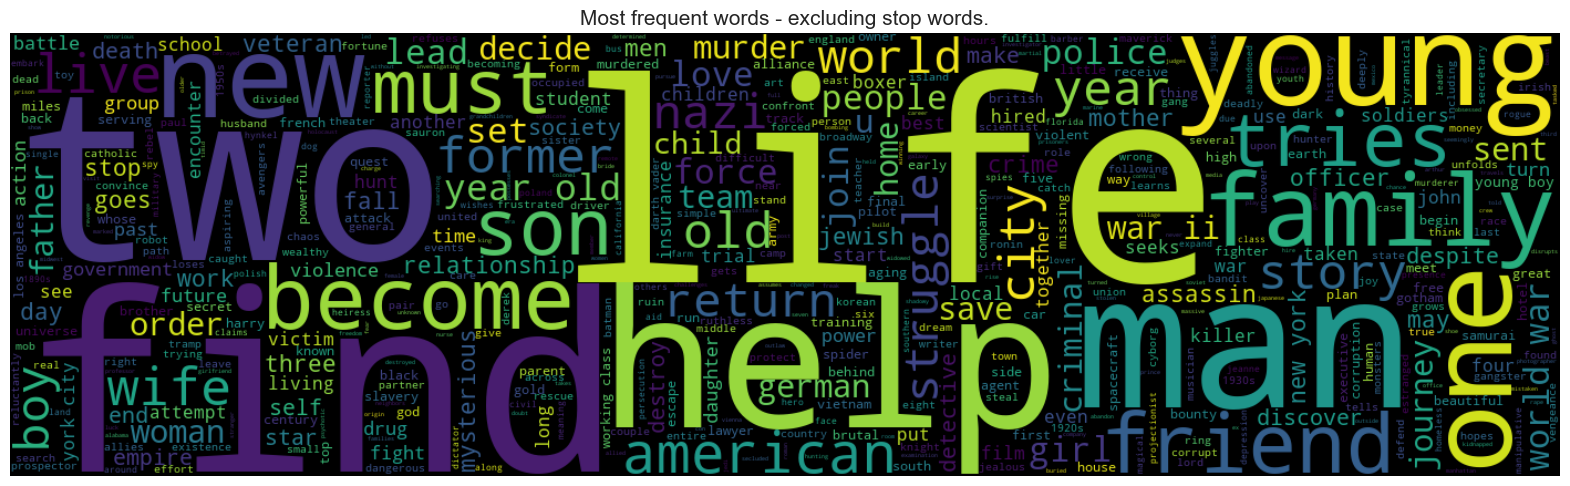

In [91]:
text = ' '.join([phrase for phrase in df['synopsis']])

plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1400, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words - excluding stop words.', fontsize = 15)
plt.show()

# Sentence Transformer Vectorization

Calculates a fixed-size vector representation (embedding) given texts or images. Embedding calculation is often efficient, embedding similarity calculation is very fast.

In [122]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
df['embeddings'] = df['synopsis'].apply(lambda x: model.encode(x))

c:\Users\guilh\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



# Clusterization - Kmeans

In [127]:
X = np.vstack(df['embeddings'].values)

2 29974.78125
3 28739.9375
4 27841.87109375
5 27226.6875
6 26769.5859375
7 26371.822265625
8 25920.029296875
9 25746.26953125
10 25325.12890625
11 25007.853515625
12 24772.96875
13 24489.20703125
14 24229.701171875
15 24089.603515625
16 23979.490234375
17 23766.63671875
18 23496.92578125
19 23299.806640625
20 23028.0234375
21 22974.2265625
22 22861.49609375
23 22529.55078125
24 22298.806640625
25 22270.927734375
26 22082.33203125
27 21819.484375
28 21679.7734375
29 21473.9609375
30 21357.25390625
31 21154.861328125
32 20900.3828125
33 21031.13671875
34 20778.62890625
35 20651.423828125
36 20382.15625
37 20443.45703125
38 20089.09375
39 19984.59765625
40 19730.96484375
41 19729.67578125
42 19573.33984375
43 19482.26171875
44 19154.490234375
45 19102.697265625
46 18931.83203125
47 18893.01953125
48 18653.9375
49 18482.44140625
50 18549.5546875
51 18082.39453125
52 18134.615234375
53 18018.439453125
54 17851.583984375
55 17622.265625
56 17566.3828125
57 17637.8828125
58 17201.263671875
59

Text(0, 0.5, 'WCSS')

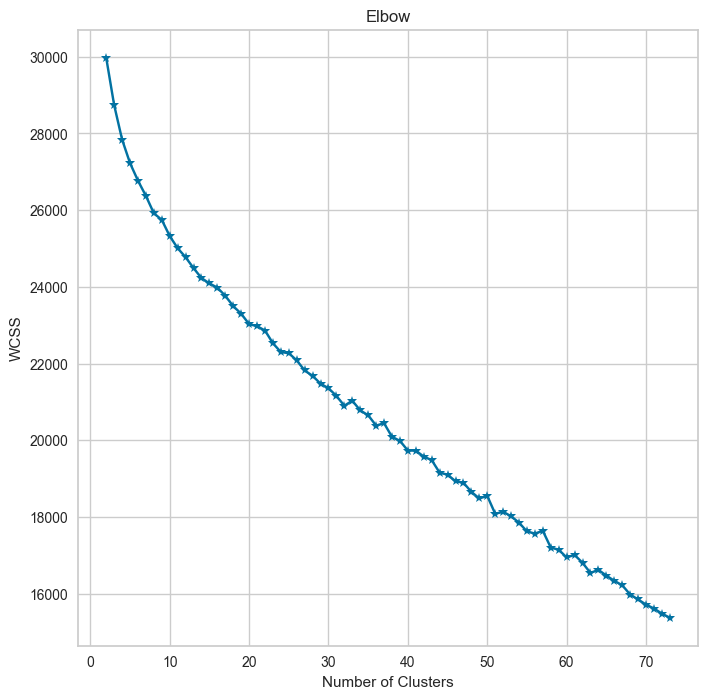

In [128]:
plt.figure(figsize = (8,8))

wcss = []

for i in range(2, df['genre'].nunique()+1):
  kmeans = KMeans(n_clusters = i, init = 'random')
  kmeans.fit(X)
  print(i, kmeans.inertia_)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, df['genre'].nunique()+1), wcss, '*-')
plt.title('Elbow')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS') #within cluster sum of square

A good number of clusters can be around 6 to 10 or 15 clusters. These numbers indicate reasonable inertia without becoming overly complex.

# Silhouette method

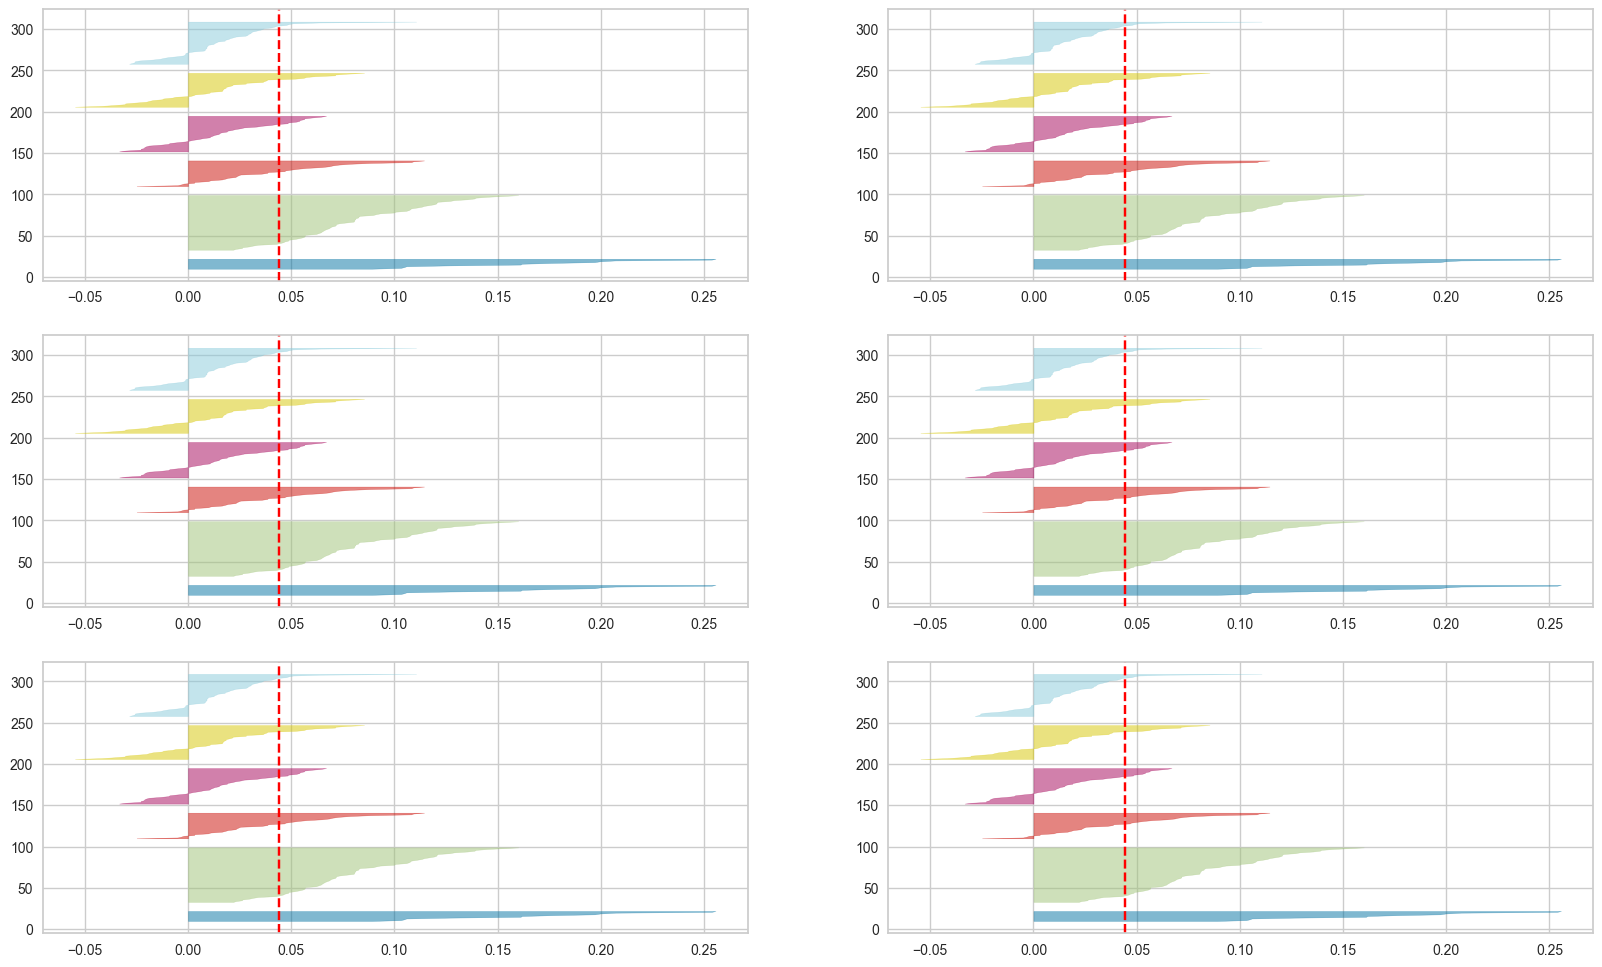

In [133]:
fig, ax = plt.subplots(3,2, figsize = (20,12))
for i in range(6):  # Adjusted loop to match the number of subplots
    #Creating KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters = 6, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)  # Calculate row and column indices

    #Creating SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q][mod])  # Access correct subplot
    visualizer.fit(X)

# Training model

In [134]:
# initialize kmeans with 5 centroids
kmeans = KMeans(n_clusters=6, random_state=42)

# fit the model
kmeans = kmeans.fit(X)

#predicting the clusters and store cluster labels in a variable
labels = kmeans.predict(X)

#getting the cluster centers
c = kmeans.cluster_centers_

df['cluster'] = labels
df.head()

,title_en,year,rating,genre,synopsis,genre_grouped,word_count,embeddings,cluster
0,The Kid,1921,8.2,Buddy Comedy,tramp cares abandoned child events put relatio...,Comedy,8,"[0.05797492, 0.35088265, 1.1779296, 0.5049271,...",2
1,Sherlock Jr.,1924,8.2,Bumbling Detective,film projectionist longs detective puts meagre...,Comedy,14,"[-0.3760612, 0.8228122, 0.59040713, 0.425472, ...",5
2,The Gold Rush,1925,8.1,Farce,prospector goes klondike 1890s gold rush hopes...,Comedy,14,"[-0.27339333, 0.7839603, 0.09991155, 0.4750157...",2
3,The General,1926,8.1,Farce,rejected confederate military realizing due cr...,Comedy,20,"[-0.44990852, 0.8168888, 0.64323425, 0.8275301...",4
4,Metropolis,1927,8.3,Dystopian Sci-Fi,futuristic city sharply divided working class ...,Sci-Fi,20,"[-0.34269443, 0.971742, 0.92792064, 0.11452965...",4


# Evaluation

## Movies per Cluster

In [137]:
fig = px.bar(df['cluster'].value_counts(),
             text_auto = True,
             title = 'Amount of Movies per Cluster',
             labels = {'index': 'Cluster',
                       'value':'Amount of Movies'})
fig.show()

## Year per Cluster

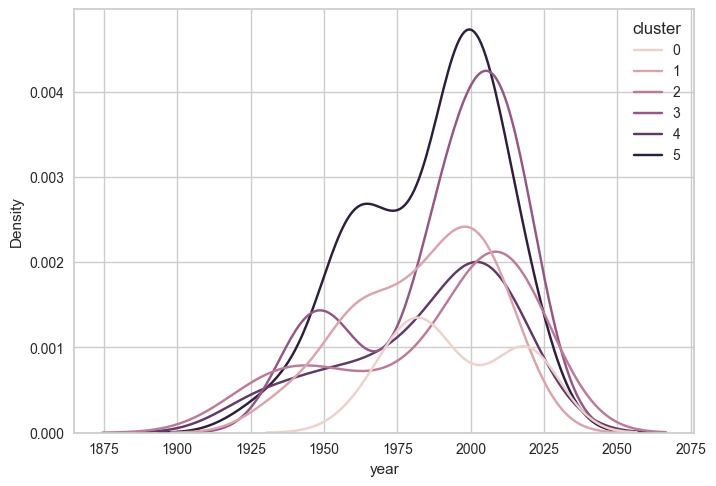

In [140]:
sns.kdeplot(df, x = 'year', hue = 'cluster');

## Genre per Cluster

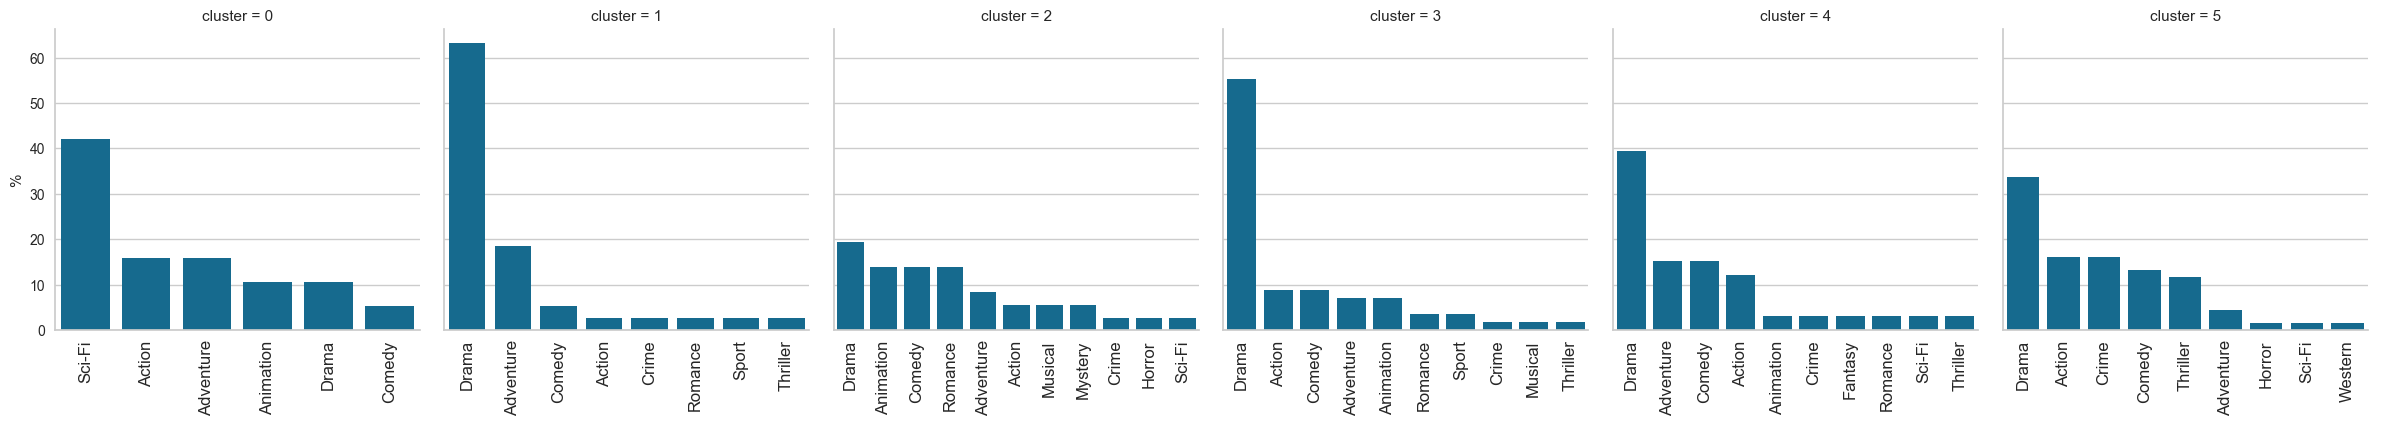

In [148]:
df_plot = df.groupby(['cluster', 'genre_grouped'])['title_en'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_en':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre_grouped", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 12);

# Save final dataset

In [185]:
df.to_excel('./deploy-streamlit/Xtest.xlsx', index=False)

# Validate

In [182]:
new_synopsis = "american car designer carroll shelby driver"

new_embedding = model.encode(new_synopsis)

Xtest = np.vstack(df['embeddings'].values)  # Certifique-se de que df['embeddings'] seja uma lista de arrays

similarities = cosine_similarity([new_embedding], Xtest)[0]  # Retorna um array com as similaridades

most_similar_index = similarities.argmax()  # Índice do maior valor de similaridade

target_cluster = df.iloc[most_similar_index]['cluster']

cluster_movies = df[df['cluster'] == target_cluster]

cluster_embeddings = np.vstack(cluster_movies['embeddings'].values)
cluster_similarities = cosine_similarity([new_embedding], cluster_embeddings)[0]

top_indices_in_cluster = cluster_similarities.argsort()[-5:][::-1]  # Índices dos 5 maiores valores, em ordem decrescente

recommended_movies = cluster_movies.iloc[top_indices_in_cluster]

recommended_movies[['title_en', 'cluster', 'synopsis']]

,title_en,cluster,synopsis
239,Ford v Ferrari,0,american car designer carroll shelby driver ke...
247,Oppenheimer,0,story american scientist j robert oppenheimer ...
87,Blade Runner,0,blade runner must pursue terminate four replic...
62,2001: A Space Odyssey,0,uncovering mysterious artifact buried beneath ...
86,The Thing,0,research team antarctica hunted shape-shifting...
